## Name: Margaret Nguyen

# Exploring the Impact of Infrastructure on Incident Rates for Vulnerable Road Users: A Machine Learning Analysis

**In this coding project, my primary objective is to develop predictive models that assess the influence of infrastructure on incident rates, particularly among vulnerable road users such as cyclists and pedestrians, over the years 2017 to 2021. To achieve this, I will utilize the Pennsylvania and Massachusetts crash datasets. The machine learning techniques employed in this project include Principal Component Analysis (PCA) and Ordinary Least Squares (OLS). Principal Component Analysis (PCA) will aid in dimensionality reduction, while Ordinary Least Squares (OLS) will reveal and predict the key features that have the most significant impact on incident rates.**

- **To access cleaned Pennsylvania Crash Data merging with the BNA Score for this project, please use the [following link](https://github.com/margaret613/Carlisle_Borough_Transportation_Study/blob/main/data/df_pa_crash.csv).**

- **To access cleaned Massachusetts Crash Data merging with the BNA Score for this project, please use the [following link](https://github.com/margaret613/Carlisle_Borough_Transportation_Study/blob/main/data/df_mass_bna.csv).**

- **To access original Pennsylvania Crash Data, please use the [following link](https://pennshare.maps.arcgis.com/apps/webappviewer/index.html?id=8fdbf046e36e41649bbfd9d7dd7c7e7e).**

- **To access original Massachusetts Crash Data, please use the [following link](https://massdot-impact-crashes-vhb.opendata.arcgis.com/).**

- **To obtain the PennDOT Open Data Portal Crash Data Dictionary, you can use the [link provided](https://gis.penndot.gov/gishub/crashZip/Crash%20Data%20Dictionary%2005.2023.pdf).**

In [3]:
# Import packages
import numpy as np # v 1.21.5
import sklearn # v 1.0.2
import pandas as pd # v 1.4.4
import ydata_profiling as pp # v 3.6.6
import statsmodels.api as sm # v 0.13.2

# Regression
from sklearn.linear_model import LinearRegression # v 1.0.2
from sklearn.model_selection import train_test_split # v 1.0.2

# PCA
from sklearn.decomposition import PCA # v 1.0.2
from sklearn.preprocessing import StandardScaler # v 1.0.2

from sklearn.metrics import mean_absolute_error # v 1.0.2
from sklearn.metrics import mean_squared_error # v 1.0.2
from sklearn.metrics import mean_absolute_percentage_error # v 1.0.2

# Ploting libraries 
import matplotlib
#matplotlib.use('Qt5Agg')  # Use an appropriate backend like 'Qt5Agg' for GUI display
import matplotlib.pyplot as plt # v 3.5.2
import seaborn as sns # v 0.11.2
# Display any generated plots or visualizations directly in the notebook interface
%matplotlib inline 

# Convert jupyter notebook
from nbconvert import HTMLExporter
import nbformat

# I. Data Manipulation

In [4]:
# Read the csv file 
df_pa_bna = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/df_pa_crash.csv')

# Read the csv file 
df_mass_bna = pd.read_csv('/Users/margaret06/Documents/GitHub/Carlisle_Borough_Transportation_Study/data/df_mass_bna.csv', low_memory=False)

## A. Clean the Pennsylvania Crash Dataset

In [5]:
# Clean datasets
df_pa_bna.drop(columns = ['Unnamed: 0'], inplace=True)

# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_pa_bna.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_pa_crash = df_pa_bna[numeric_columns.columns]

# Drop unnessary columns
df_pa_crash = df_pa_crash.drop(['PENN_DOT_MUNI_ID', 'state', 'county', 'county_subdivision', 'LAND_AREA.1', 'LAND_AREA', 'PENN_DOT_COUNTY_NUM', 'FEDERAL_EIN_CODE', 'HOME_RULE_YEAR', 'INCORPORATION_YEAR', 'MUNICIPALITY'], axis=1)

# Replace NaN values with 0 throughout the DataFrame to address missing data, following the experience of cleaning the original dataset.
df_pa_crash = df_pa_crash.fillna(0)

# Rename BNA Score column to BNA_SCORE column
df_pa_crash.rename(columns={'BNA Score': 'BNA_SCORE'}, inplace=True)

# Reset index
df_pa_crash.reset_index(inplace = True, drop = True)

In [6]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'EMPLOYEES_FULL_TIME',
    'EMPLOYEES_PART_TIME', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
    'BICYCLE_SOLO_COUNT', 'BICYCLE_DEATH_SOLO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT', 'PED_SOLO_COUNT',
    'PED_DEATH_SOLO_COUNT', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT'
]

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_pa_crash[new_column_name] = df_pa_crash[column] / df_pa_crash['POPULATION']

## B. Clean the Massachusett Crash Dataset

In [7]:
# Clean datasets
df_mass_bna.drop(columns = ['Unnamed: 0'], inplace=True)

# Exclude the NaN from 'VEHC_CONFIG_CL'
df_mass_crash = df_mass_bna[df_mass_bna['VEHC_CONFIG_CL'].notna()]

# List of NOT automobiles: Snowmobile, Moped, Motorcycle, Other Light Trucks (10,000 lbs., or Less), Other e.g. Farm Equipment, Unknown.
# Exclude the non-automobiles from 'VEHC_CONFIG_CL' columns
list_non_automobiles = ['V1:(Unknown vehicle configuration)', 'V1:(Other e.g. farm equipment)', 'V1:(Unknown vehicle configuration) / V2:(Unknown vehicle configuration)']
df_mass_crash= df_mass_crash[~df_mass_crash['VEHC_CONFIG_CL'].isin(list_non_automobiles)]

In [8]:
# Fatal - injuries that resulted in death 
# Incapacitating - serious injuries require immediate medical attention

## BICYCLE_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for cyclist fatalities
cyclist_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
bicycle_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_DEATH_BY_AUTO_COUNT')

# Merge the bicycle_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_death_counts, on='CITY_TOWN_NAME', how='left')

## BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
cyclist_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]
bicycle_sus_serious_inj_counts = cyclist_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the bicycle_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

## BICYCLE_BY_AUTO_COUNT
df_mass_crash['BICYCLE_BY_AUTO_COUNT'] = df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'] + df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

## AUTOMOBILE_COUNT
auto_count = df_mass_crash.groupby('CITY_TOWN_NAME')['NUMB_VEHC'].sum().reset_index()
auto_count.rename(columns={'NUMB_VEHC': 'AUTOMOBILE_COUNT'}, inplace=True)
# Merge the auto_count into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(auto_count, on='CITY_TOWN_NAME', how='left')

## PED_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for pedestrian fatalities
ped_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
ped_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_DEATH_BY_AUTO_COUNT')

# Merge the ped_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_death_counts, on='CITY_TOWN_NAME', how='left')

## PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
ped_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]
ped_sus_serious_inj_counts = ped_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the ped_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['PED_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

##PED_BY_AUTO_COUNT
df_mass_crash['PED_BY_AUTO_COUNT'] = df_mass_crash['PED_DEATH_BY_AUTO_COUNT'] + df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Drop the duplicated rows
df_mass_crash = df_mass_crash.drop_duplicates(subset=['CITY_TOWN_NAME', 'BNA Score', 'POPULATION', 
                                                      'BIKE_TO_WORK_EST', 'BICYCLE_BY_AUTO_COUNT', 
                                                      'BICYCLE_DEATH_BY_AUTO_COUNT', 
                                                      'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 
                                                      'AUTOMOBILE_COUNT', 'PED_BY_AUTO_COUNT', 
                                                      'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'])

In [9]:
# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_mass_crash.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_mass_crash = df_mass_crash[numeric_columns.columns]

# Rename BNA Score column to BNA_SCORE column
df_mass_crash.rename(columns={'BNA Score': 'BNA_SCORE'}, inplace=True)

# Reset index
df_mass_crash.reset_index(drop = True, inplace = True)

In [10]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_mass_crash[new_column_name] = df_mass_crash[column] / df_mass_crash['POPULATION']

**Create dumnmy variable for each dataframe**

In [11]:
df_pa_crash['penn'] = 1
df_mass_crash['penn'] = 0

In [12]:
# Drop columns that df_mass_crash does not have
drop_columns = ['EMPLOYEES_FULL_TIME', 'EMPLOYEES_PART_TIME', 'BICYCLE_SOLO_COUNT', 'BICYCLE_DEATH_SOLO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT', 'PED_SOLO_COUNT', 'PED_DEATH_SOLO_COUNT', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT', 'EMPLOYEES_FULL_TIME_PER_CAPITA', 'EMPLOYEES_PART_TIME_PER_CAPITA', 'BICYCLE_SOLO_COUNT_PER_CAPITA', 'BICYCLE_DEATH_SOLO_COUNT_PER_CAPITA', 'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT_PER_CAPITA', 'PED_SOLO_COUNT_PER_CAPITA', 'PED_DEATH_SOLO_COUNT_PER_CAPITA', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT_PER_CAPITA']
df_pa_crash = df_pa_crash.drop(columns=drop_columns)

# Reorder the columns of the df_mass_crash to match df_pa_crash
df_mass_crash = df_mass_crash[df_pa_crash.columns]

In [13]:
# Print the shape of each datadrame
df_mass_crash.shape, df_pa_crash.shape

((45, 37), (44, 37))

## C. Merge df_pa_crash and df_mass_crash Dataframes

In [14]:
df_crash_bna = pd.concat([df_pa_crash, df_mass_crash], axis=0)
# Reset index
df_crash_bna.reset_index(drop = True, inplace = True)

# Show merge dataframe
df_crash_bna.head()

,POPULATION,BIKE_TO_WORK_EST,BIKE_TO_WORK_MARG,WALK_TO_WORK_EST,WALK_TO_WORK_MARG,DRIVE_SOLO_TO_WORK_EST,DRIVE_SOLO_TO_WORK_MARG,CARPOOL_TO_WORK_EST,CARPOOL_TO_WORK_MARG,PUBTRANS_TO_WORK_EST,...,PUBTRANS_TO_WORK_EST_PER_CAPITA,PUBTRANS_TO_WORK_MARG_PER_CAPITA,AUTOMOBILE_COUNT_PER_CAPITA,BICYCLE_BY_AUTO_COUNT_PER_CAPITA,BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA,BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,PED_BY_AUTO_COUNT_PER_CAPITA,PED_DEATH_BY_AUTO_COUNT_PER_CAPITA,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,penn
0,125250,79,51,2396,607,36549,1464,8407,817,2039,...,0.016279,0.003162,0.002443,0.000383,0.0,0.000032,0.001964,0.000016,0.000232,1
1,44114,4,6,761,210,14943,816,1391,269,508,...,0.011516,0.004738,0.001065,0.000204,0.0,0.000023,0.000816,0.000023,0.000113,1
2,3268,0,11,0,11,1397,231,109,79,11,...,0.003366,0.005202,0.000306,0.000000,0.0,0.000000,0.000306,0.000000,0.000000,1
3,4438,0,11,75,56,1404,197,108,64,0,...,0.000000,0.002479,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
4,1600,0,11,25,14,686,125,76,52,0,...,0.000000,0.006875,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1


In [15]:
# Check for the shape of the datafrane
df_crash_bna.shape

(89, 37)

In [16]:
# Check for NaN missing values
df_crash_bna.isna().sum()

POPULATION                                           0
BIKE_TO_WORK_EST                                     0
BIKE_TO_WORK_MARG                                    0
WALK_TO_WORK_EST                                     0
WALK_TO_WORK_MARG                                    0
DRIVE_SOLO_TO_WORK_EST                               0
DRIVE_SOLO_TO_WORK_MARG                              0
CARPOOL_TO_WORK_EST                                  0
CARPOOL_TO_WORK_MARG                                 0
PUBTRANS_TO_WORK_EST                                 0
PUBTRANS_TO_WORK_MARG                                0
AUTOMOBILE_COUNT                                     0
BICYCLE_BY_AUTO_COUNT                                0
BICYCLE_DEATH_BY_AUTO_COUNT                          0
BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT               0
PED_BY_AUTO_COUNT                                    0
PED_DEATH_BY_AUTO_COUNT                              0
PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT                   0
BNA_SCORE 

**Use Pandas Profiling**

In [17]:
#pp.ProfileReport(df_crash_bna)

The BICYCLE_DEATH_BY_AUTO_COUNT variable is imbalanced.

# II. Principal Component Analysis (PCA)

### Credit: 
**The following code presented here is built upon the work of my supervisor, Mitch Shiles. You can access the original code by following this link: [Mitch Shiles' GitHub](https://github.com/rmshiles/Textiles-Spectroscopy-and-Supervised-Learning/blob/master/spectral%20analysis%20Final%20version.ipynb). I have made some adjustments to streamline and improve the code, aligning it with our specific usage requirements. I obtained permission from my supervisor to review and utilize his code for this internship project.**

In [18]:
# Copy df_crash_bna as df_crash_filtered
df_crash_filtered = df_crash_bna.copy()

# Drop the binary column while running the PCA
df_crash_filtered.drop(columns=['penn', 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA', 'PED_BY_AUTO_COUNT_PER_CAPITA'], inplace=True)

In [19]:
# Normalize the features
crash_scaler = StandardScaler()
crash_std = crash_scaler.fit_transform(df_crash_filtered)

In [20]:
# Create a function to display the explained Variance related to principle components
def Number_of_Principle_Components(X_standardized,n_components):
    #Dimensionality reduction 
    # conduct principle compenent analysis on the data and examine the explained variance of the components
    from sklearn.decomposition import PCA
    sklearn_pca = PCA(n_components=n_components)
    Y_sklearn = sklearn_pca.fit_transform(X_standardized)
    pca = sklearn_pca.fit_transform(crash_std)
    plt.plot(sklearn_pca.explained_variance_ratio_)
    plt.show()
    print(
        'The percentage of total variance in the dataset explained by each',
        'component from Sklearn PCA.\n',
        sklearn_pca.explained_variance_ratio_
    )

    explained_variance = []
    explained_variance = sklearn_pca.explained_variance_ratio_

    total_variace = 0
    total_variace = 0
    components = 0
    num_prints = 0
    print('\n')
    for v in explained_variance:
        total_variace+=v
        components +=1

        if total_variace>=0.5 and total_variace<0.7 and num_prints < 1 :
            print(" to retain {}% of total variance  {} components are required".format(round(100*total_variace,2),components))
            num_prints+=1

        if total_variace>=0.7 and total_variace<0.8 and num_prints < 2 :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        elif total_variace>=0.8 and total_variace<0.9 and num_prints < 3 :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        elif total_variace>=0.9 and num_prints < 4  :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        else:
            None

    print(sum(explained_variance))

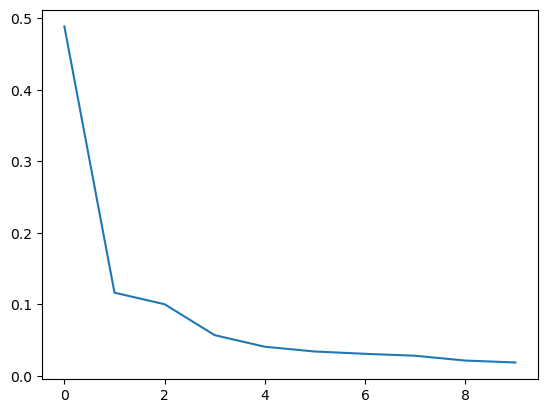

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.48875896 0.11647361 0.10028594 0.05703723 0.04082575 0.03417868
 0.0309535  0.02825603 0.02153154 0.01883386]


 to retain 60.52% of total variance  2 components are required
 to retain 70.55% of total variance 3 components required
 to retain 80.34% of total variance 5 components required
 to retain 91.83% of total variance 9 components required
0.9371350953467554


In [21]:
Number_of_Principle_Components(crash_std,10)

In [22]:
n_components = 5
pca = PCA(n_components)
crash_pca_components = pca.fit_transform(crash_std)
print(crash_pca_components[:5, :])

[[ 1.92221578 -0.87302481 -1.43210637  0.68626294  1.34483381]
 [-0.62443478 -0.56874909 -1.04947456  0.5035034   0.00495719]
 [-2.30032803 -1.86157577  0.9584754  -0.0994864  -0.03390139]
 [-1.88728126 -0.47127464  0.55724801  0.43308876 -0.12966142]
 [-2.49543778 -1.57523173  2.29660105  0.17358085  0.74085968]]


In [23]:
df_crash_filtered[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5"]] = crash_pca_components[:]
df_crash_filtered[["PCA1","PCA2","PCA3","PCA4","PCA5"]].head()

,PCA1,PCA2,PCA3,PCA4,PCA5
0,1.922216,-0.873025,-1.432106,0.686263,1.344834
1,-0.624435,-0.568749,-1.049475,0.503503,0.004957
2,-2.300328,-1.861576,0.958475,-0.099486,-0.033901
3,-1.887281,-0.471275,0.557248,0.433089,-0.129661
4,-2.495438,-1.575232,2.296601,0.173581,0.740860


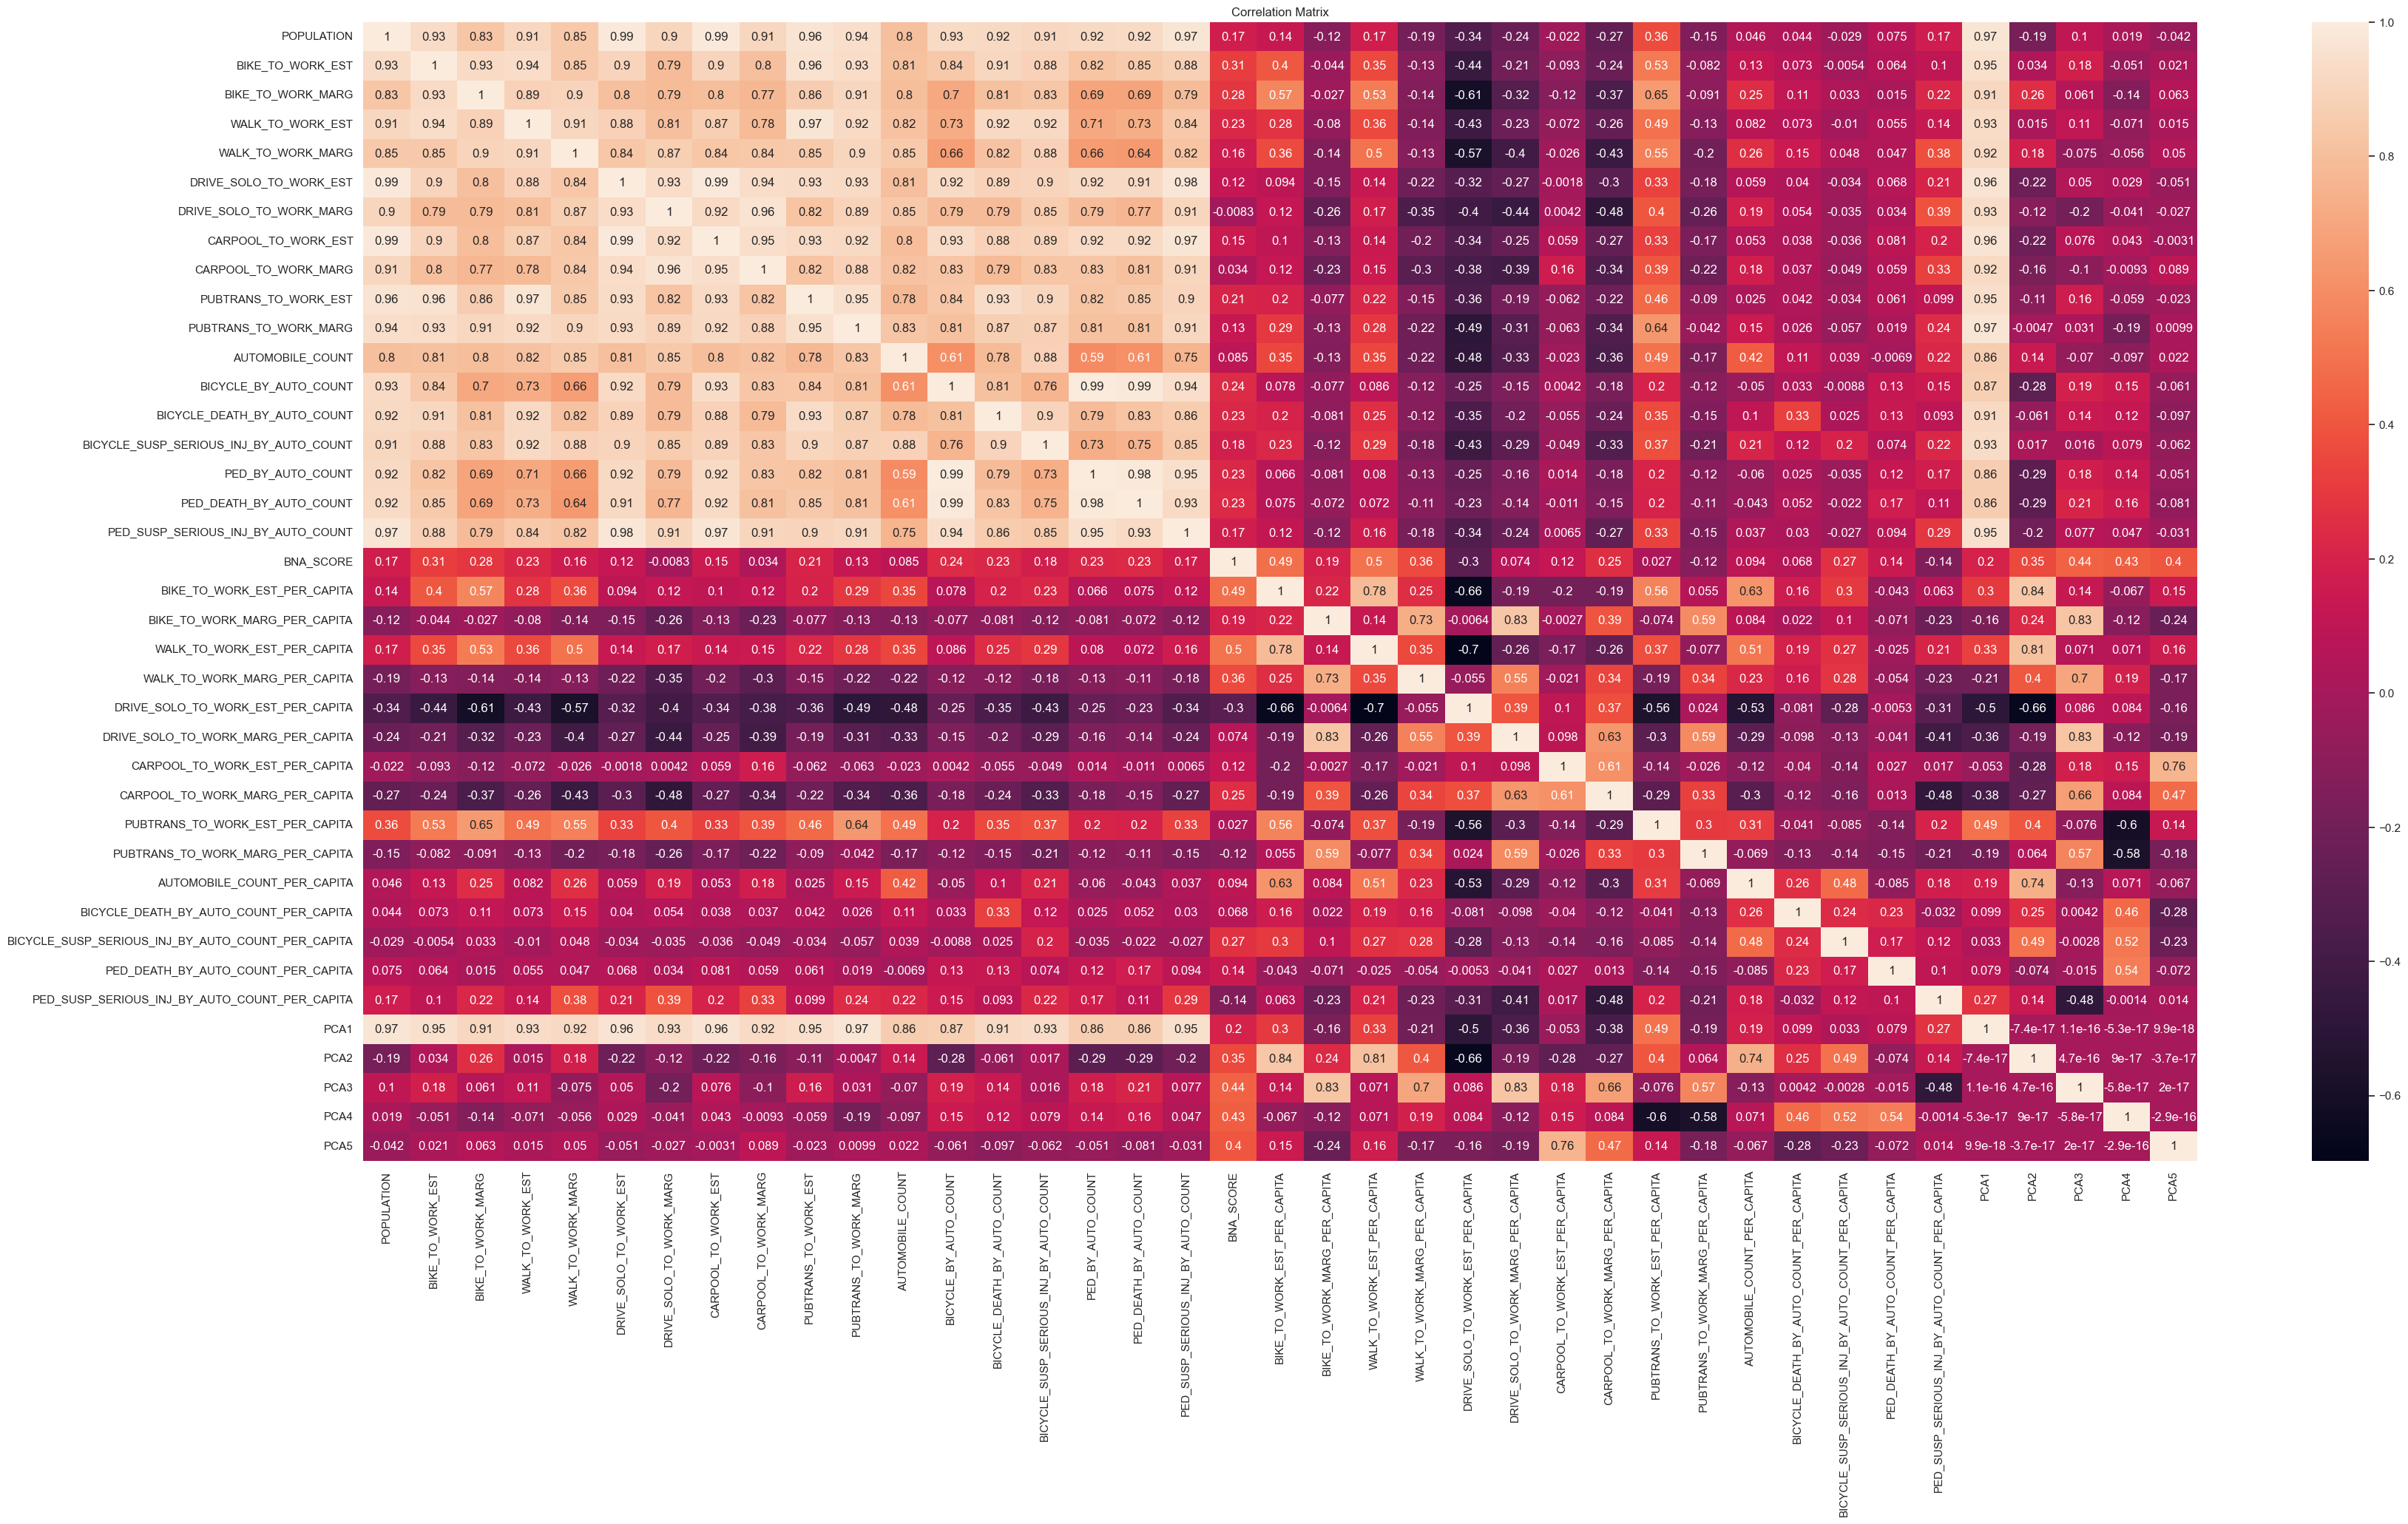

In [24]:
# Create heatmap
heat_corr = df_crash_filtered[['POPULATION', 'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
       'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
       'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
       'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST', 'PUBTRANS_TO_WORK_MARG',
       'AUTOMOBILE_COUNT', 'BICYCLE_BY_AUTO_COUNT',
       'BICYCLE_DEATH_BY_AUTO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
       'PED_BY_AUTO_COUNT', 'PED_DEATH_BY_AUTO_COUNT',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'BNA_SCORE',
       'BIKE_TO_WORK_EST_PER_CAPITA', 'BIKE_TO_WORK_MARG_PER_CAPITA',
       'WALK_TO_WORK_EST_PER_CAPITA', 'WALK_TO_WORK_MARG_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA',
       'CARPOOL_TO_WORK_MARG_PER_CAPITA', 'PUBTRANS_TO_WORK_EST_PER_CAPITA',
       'PUBTRANS_TO_WORK_MARG_PER_CAPITA', 'AUTOMOBILE_COUNT_PER_CAPITA',
       'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA',
       'PED_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 'PCA1', 'PCA2', 'PCA3',
       'PCA4', 'PCA5']].corr()

plt.figure(figsize=(40,20))
sns.set(rc={ 'figure.facecolor':'w'})
sns.heatmap(heat_corr, annot=True) 
plt.title("Correlation Matrix")

# Save the heatmap as a PNG file
plt.savefig('correlation_heatmap.png', format='png')
plt.show()

In [25]:
# Add PCA components into the dataframe
df_crash_bna[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5"]] = crash_pca_components[:]

In [26]:
# Check to see of the BNA score has a strong correlation with PCAs.
df_crash_bna[['BNA_SCORE', 'PCA1', 'PCA2',
       'PCA3', 'PCA4', 'PCA5']].corr()

,BNA_SCORE,PCA1,PCA2,PCA3,PCA4,PCA5
BNA_SCORE,1.000000,2.032780e-01,3.531764e-01,4.376385e-01,4.271831e-01,4.021840e-01
PCA1,0.203278,1.000000e+00,-7.350351e-17,1.067234e-16,-5.251854e-17,9.869848e-18
PCA2,0.353176,-7.350351e-17,1.000000e+00,4.718699e-16,8.957801e-17,-3.671213e-17
PCA3,0.437638,1.067234e-16,4.718699e-16,1.000000e+00,-5.821345e-17,2.006884e-17
PCA4,0.427183,-5.251854e-17,8.957801e-17,-5.821345e-17,1.000000e+00,-2.889207e-16
PCA5,0.402184,9.869848e-18,-3.671213e-17,2.006884e-17,-2.889207e-16,1.000000e+00


**According to the correlation table, we should incorporate BNA Score into the PCA to avoid multicollinearity and add it to the model because it does not exhibit a strong correlation with the PCAs.**

# III. Ordinary Least Squares (OLS)

## A. Separate Dataset in Y (independent) and X (dependent) Variables

In [27]:
y = df_crash_bna["BICYCLE_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.BICYCLE_BY_AUTO_COUNT_PER_CAPITA
X = df_crash_bna[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5","penn","BNA_SCORE"]] 

In [28]:
y2 = df_crash_bna["PED_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.PED_BY_AUTO_COUNT_PER_CAPITA
X2 = df_crash_bna[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5","penn","BNA_SCORE"]] 

## B. Use the train_test_split Function to Split Data into Training (80%) and Testing Set (20%)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [30]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=5)

## C. Fit, Run or Estimate the Regression Model

### 1. BICYCLE_BY_AUTO_COUNT_PER_CAPITA as the Dependent Variable

In [31]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     BICYCLE_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.472
Model:                                          OLS   Adj. R-squared:                  0.413
Method:                               Least Squares   F-statistic:                     8.036
Date:                              Mon, 30 Oct 2023   Prob (F-statistic):           5.95e-07
Time:                                      13:16:46   Log-Likelihood:                 519.82
No. Observations:                                71   AIC:                            -1024.
Df Residuals:                                    63   BIC:                            -1006.
Df Model:                                         7                                         
Covariance Type:                          nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    

In [32]:
# Make predictions on the test data
X_test = sm.add_constant(X_test)  # Add a constant term to the test data
y_pred = model.predict(X_test)

### 2. PED_BY_AUTO_COUNT_PER_CAPITA as the Dependent Variable

In [33]:
X_train2 = sm.add_constant(X_train2)
model2 = sm.OLS(y_train2, X_train2).fit()
print(model2.summary())

                                 OLS Regression Results                                 
Dep. Variable:     PED_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.632
Model:                                      OLS   Adj. R-squared:                  0.591
Method:                           Least Squares   F-statistic:                     15.47
Date:                          Mon, 30 Oct 2023   Prob (F-statistic):           1.32e-11
Time:                                  13:16:46   Log-Likelihood:                 450.53
No. Observations:                            71   AIC:                            -885.1
Df Residuals:                                63   BIC:                            -866.9
Df Model:                                     7                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [34]:
# Make predictions on the test data
X_test2 = sm.add_constant(X_test2)  # Add a constant term to the test data
y_pred2 = model.predict(X_test2)

## D. Plot the Residuals

### Graph 1: The residuals for the model with 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

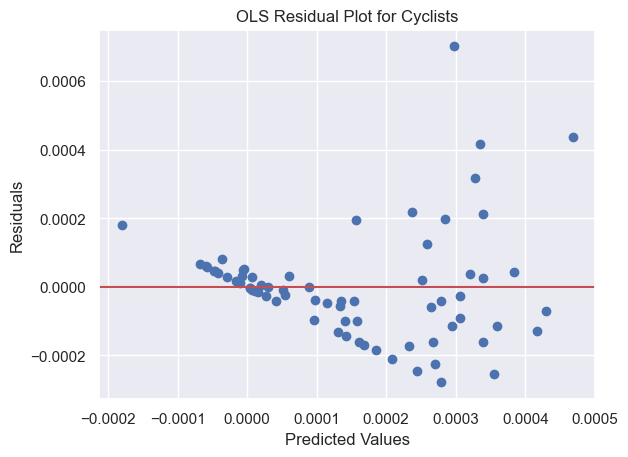

In [35]:
residuals = model.resid

plt.scatter(model.fittedvalues, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot for Cyclists")
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.show()

### Graph 2: The residuals for the model with 'PED_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

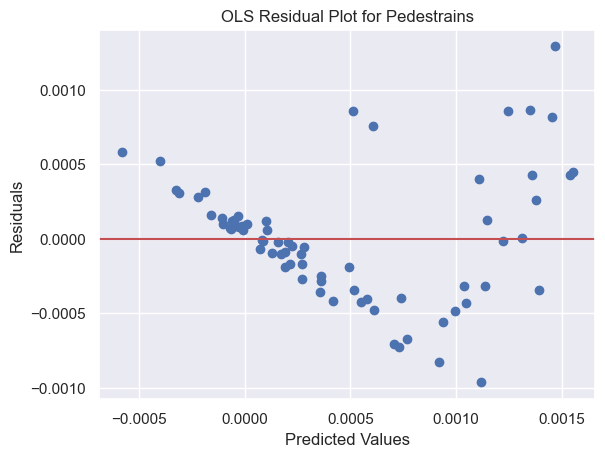

In [36]:
residuals2 = model2.resid

plt.scatter(model2.fittedvalues, residuals2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("OLS Residual Plot for Pedestrains")
plt.axhline(y=0, color='r', linestyle='-')  # Add a horizontal line at y=0
plt.show()

## E. Plot the Actual vs. Predicted Values

### Graph 3: The Actual vs. Predicted Values for the model with 'BICYCLE_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

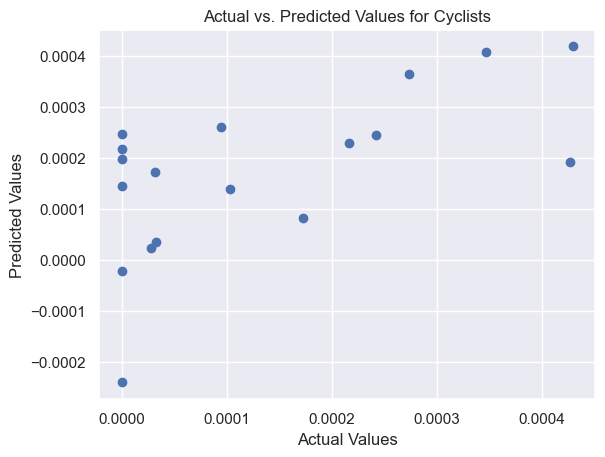

In [37]:
# Plot the actual vs. predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for Cyclists")
plt.show()

### Graph 4: The Actual vs. Predicted Values for the model with 'PED_BY_AUTO_COUNT_PER_CAPITA' as the dependent variable

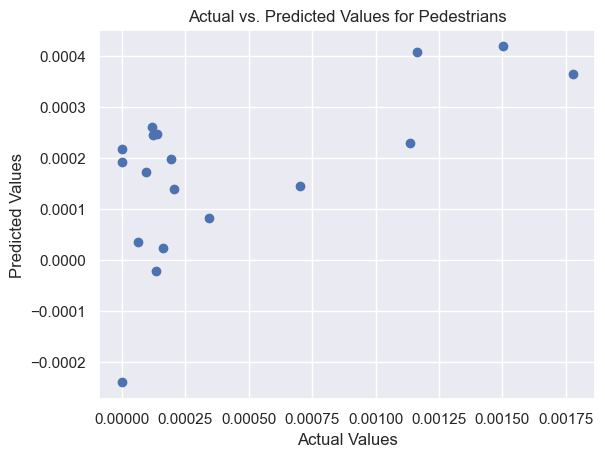

In [38]:
# Plot the actual vs. predicted values
plt.scatter(y_test2, y_pred2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values for Pedestrians")
plt.show()

## IV. Report

According to the OLS results and the graphs I have plotted, it is evident that this model does not perform well. Despite applying the PCA model to reduce dimensionality, it is essential to note that PCA models are inherently challenging to interpret. This lack of interpretability leads to a deficit in meaningful insights for the OLS model. Additionally, Graphs 1 and 2 clearly illustrate that my model inadequately predicts the fitted (predicted) values.

To address these issues, I recommend the following steps:

1. **Increase Data Collection**: To improve the model's performance, it is advisable to gather more crash datasets from various states with BNA scores. The current dataset size is too limited, and increasing the data can lead to more robust and accurate results.

2. **Utilize Stepwise Regression**: Instead of PCA, I suggest employing stepwise regression with both forward and backward selection techniques. This will help in the systematic inclusion and exclusion of variables, optimizing the model's predictive power.

3. **Apply Akaike Information Criterion (AIC)**: In the stepwise regression process, make use of the Akaike Information Criterion (AIC) to determine the best model among the potential candidates. AIC is a valuable tool for model selection as it balances the goodness of fit with the complexity of the model.

By implementing these recommendations, I believe that I can enhance the model's performance, interpretability, and overall predictive power, leading to more insightful outcomes for the next step in the progress.

In [7]:
# Load the Jupyter notebook
notebook = nbformat.read('crash_analysis_machine_learning.ipynb', as_version=4)

# Initialize the HTML exporter
html_exporter = HTMLExporter()

# Convert the notebook to HTML
(html, resources) = html_exporter.from_notebook_node(notebook)

# Save the HTML to a file
with open('crash_analysis_machine_learning.html', 'w', encoding='utf-8') as f:
    f.write(html)